In [1]:
import sys
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python/")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/")
sys.path.append("/home/rossidaniel/Dropbox")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python")

In [2]:
import Bin_Packing_Py as BP
import BP_print
import BP_plot
import BP_utilities
import HA_routines
import BP_instances

import matplotlib
%matplotlib nbagg
matplotlib.rcParams['figure.figsize'] = [6,3.5]

from ortools.linear_solver import pywraplp
import random
import time
import csv

import pandas as pd
from sqlalchemy import create_engine
from mail import send_mail
from Test_BP_G import euristic

In [3]:
class model_bin_packing:
    def __init__(self,item_list,bin_list):
        self.bp = BP.BinPack()
        self.bp.items.extend(item_list)
        self.bp.bins.extend(bin_list)
        
    def buildModel(self,amount_time=300000):
        solver = pywraplp.Solver('Model2DR', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
        #importo dimensioni dei pacchi e del camion
        n=len(self.bp.items)

        w =[self.bp.items[i].width for i in range(n)]
        d =[self.bp.items[i].depth for i in range(n)]
        h =[self.bp.items[i].height for i in range(n)]
        M=sum([max(w[i],d[i]) for i in range(n)])

        W =self.bp.bins[0].width
        D =solver.NumVar(0,M,"D")
        H =self.bp.bins[0].height
        
        Mw=W+M
        Md=self.bp.bins[0].depth+M
        Mz=H+max(h)
                
        # definisco le variabili
        l =[[solver.BoolVar("l%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        b =[[solver.BoolVar("b%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        r =[solver.BoolVar("r%d" % (i)) for i in range(n)]

        x =[solver.NumVar(0,solver.infinity(),"x%d" % i) for i in range(n)]
        y =[solver.NumVar(0,solver.infinity(),"y%d" % i) for i in range(n)]


        #definisco i constraints
        for i in range(n):
            for j in range(n):
                if(i < j):
                    solver.Add(l[i][j] + l[j][i] + b[i][j] + b[j][i] >= 1)                           #(1)
                if(i != j):
                    solver.Add(x[i] - x[j] + Mw * l[i][j] <= Mw - w[i]*(1-r[i]) - d[i]*r[i])         #(2)
                    solver.Add(y[i] - y[j] + Md * b[i][j] <= Md - d[i]*(1-r[i]) - w[i]*r[i])         #(3)
            solver.Add(x[i] + w[i]*(1-r[i]) + d[i]*r[i] <= W)                                        #(4)
            solver.Add(y[i] + d[i]*(1-r[i]) + w[i]*r[i] <= D)                                        #(5)

        #funzione obiettivo
        objective = solver.Objective()
        objective.SetCoefficient(D,1)
        objective.SetMinimization()

        #soluzione
        solver.SetTimeLimit(amount_time)
        t=time.time()
        solver.Solve()
        t =time.time()-t

        s = BP.Solution(self.bp)
        for i in range(len(self.bp.items)):
            rt = False if r[i].solution_value() == 0 else True
            s.pushItem(self.bp.items[i],0,BP.Point(x[i].solution_value(),y[i].solution_value(),0),rt,False)
        return s,t,w,d,h,n
    
    def BuildSolution(self,s):
        print s
    
    def plotSolution(self,s):
        BP_plot.plotSolution(s)
    
    def plot3Dsolution(self,s):
        BP_plot.plot3DSolution(s,0)

    def feasible(self):
        return self.bp.bins[0].height*self.bp.bins[0].width >= sum([self.bp.items[i].width*self.bp.items[i].height for i in range(len(self.bp.items))])

In [4]:
n_items = []
Avg_w = []
Avg_d = []
Avg_a = []
Time = []
eu_obj = []
mod_obj = []
Avg_wd = []
square_index = []

0


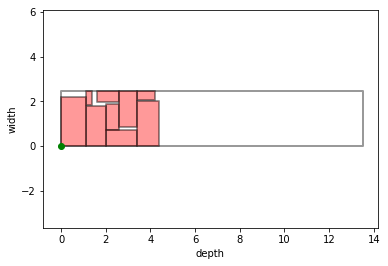

In [5]:
for i in range(1):
    if (i % 25 == 0): print i
    items,bins=BP_instances.tc_sfida()
    model = model_bin_packing(items,bins)
    s,t,w,d,h,n=model.buildModel()
    s.computeObj()
    BP_plot.plotSolution(s)
    mod_obj.append(s.obj)
    eu_obj.append(euristic(items,bins))
    Time.append(round(t,3))
    Avg_w.append(round(sum(w)/n,3))
    Avg_d.append(round(sum(d)/n,3))
    square_index.append((min(Avg_w[i],Avg_d[i])/max(Avg_w[i],Avg_d[i])*100))
    A = [w[i]*d[i] for i in range(n)]
    Avg_a.append(sum(A)/n)
    equals.append(max(A)-min(A))
    n_items.append(n)
    big.append(sum(w[i]*d[i] for i in range(n))/n)

In [6]:
dimensioni =pd.DataFrame({'n_items': n_items, 'Square_index': square_index, 'Avg width': Avg_w,'Avg depth': Avg_d,'Avg Area': Avg_a,'Eu obj': eu_obj,'Mod obj': mod_obj, 'Time': Time})

In [7]:
dimensioni.to_excel('result.xlsx', encoding='utf8')
dimensioni.to_latex('result.tex', encoding='utf8')
dimensioni.to_csv('result.csv', encoding='utf8')

In [8]:
dimensioni

,Avg Area,Avg depth,Avg width,Eu obj,Mod obj,Square_index,Time,n_items
0,1.113333,1.4,0.7,3.6,4.4,50.0,305.593,9


In [9]:
#send_mail()

In [10]:
dimensioni.drop(columns='Square_index')

,Avg Area,Avg depth,Avg width,Eu obj,Mod obj,Time,n_items
0,1.113333,1.4,0.7,3.6,4.4,305.593,9
